In [1]:
# conda activate bio 
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os 
from tqdm import tqdm
from protlearn.preprocessing import remove_unnatural
from Bio.SeqUtils.ProtParam import ProteinAnalysis 
from protlearn.features import entropy

# annots from BLDB

In [2]:
# wget log andd other commands 
! cat ../bldb/raw/readme

# each dir contains the original files downloaded from bldb 
! ls ../bldb/raw/

# log after finished the download 
wget -r -A "*fasta" http://bldb.eu/seq_prot/

Removing bldb.eu/seq_prot/index.html?C=D;O=D.tmp since it should be rejected.

FINISHED --2024-03-30 16:05:29--
Total wall clock time: 1h 43m 16s
Downloaded: 29457 files, 67M in 51s (1.31 MB/s)

# removed seqs due to empy info A-PfIII-9-prot.fasta and A-SHV-6-prot.fasta 
class A 
-rwxrwxrwx 1 gama gama  228 Nov 12  2019 A-LEN-P1-prot.fasta
-rwxrwxrwx 1 gama gama  222 Nov 12  2019 A-LEN-P2-prot.fasta
-rwxrwxrwx 1 gama gama  206 Nov 12  2019 A-SHV-P2-prot.fasta
-rwxrwxrwx 1 gama gama  199 Nov 12  2019 A-SHV-P3-prot.fasta
-rwxrwxrwx 1 gama gama    1 Dec  1 15:38 A-PfIII-9-prot.fasta
-rwxrwxrwx 1 gama gama    0 Nov 12  2019 A-SHV-6-prot.fasta

all  class_a  class_b1	class_b2  class_b3  class_c  class_d  other  readme


In [3]:
# contains the concat seqs per class as fasta,csv and only headers
! ls ../bldb/raw/all	 

csv  fasta  headers


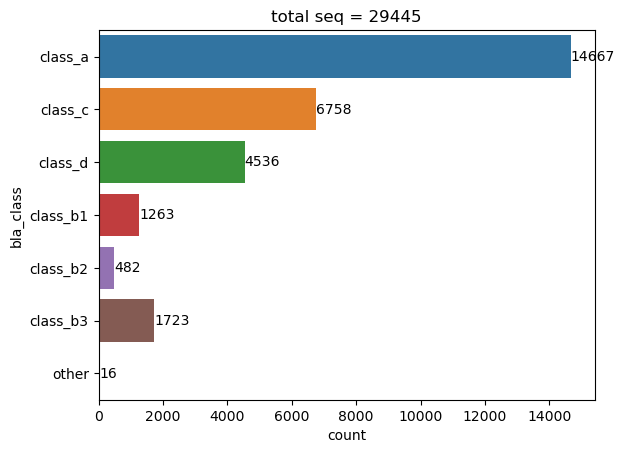

In [4]:
# load seqs
a  = pd.read_csv("../bldb/raw/all/csv/all_class_a.fasta.csv", sep="\t")
c  = pd.read_csv("../bldb/raw/all/csv/all_class_c.fasta.csv", sep="\t")
d  = pd.read_csv("../bldb/raw/all/csv/all_class_d.fasta.csv", sep="\t")
b1 = pd.read_csv("../bldb/raw/all/csv/all_class_b1.fasta.csv", sep="\t")
b2 = pd.read_csv("../bldb/raw/all/csv/all_class_b2.fasta.csv", sep="\t")
b3 = pd.read_csv("../bldb/raw/all/csv/all_class_b3.fasta.csv", sep="\t")
ot = pd.read_csv("../bldb/raw/all/csv/all_others.fasta.csv", sep="\t")

# load filenames
names_a  = pd.read_csv("../bldb/raw/all/headers/class_a.csv", names=["filename"])
names_c  = pd.read_csv("../bldb/raw/all/headers/class_c.csv", names=["filename"])
names_d  = pd.read_csv("../bldb/raw/all/headers/class_d.csv", names=["filename"])
names_b1 = pd.read_csv("../bldb/raw/all/headers/class_b1.csv", names=["filename"])
names_b2 = pd.read_csv("../bldb/raw/all/headers/class_b2.csv", names=["filename"])
names_b3 = pd.read_csv("../bldb/raw/all/headers/class_b3.csv", names=["filename"])
names_ot = pd.read_csv("../bldb/raw/all/headers/other.csv", names=["filename"])

# append class and filenames

a["filename"]  = names_a["filename"]
c["filename"]  = names_c["filename"]
d["filename"]  = names_d["filename"]
b1["filename"] = names_b1["filename"]
b2["filename"] = names_b2["filename"]
b3["filename"] = names_b3["filename"]
ot["filename"] = names_ot["filename"]

a["bla_class"]  = "class_a"
c["bla_class"]  = "class_c"
d["bla_class"]  = "class_d"
b1["bla_class"] = "class_b1"
b2["bla_class"] = "class_b2"
b3["bla_class"] = "class_b3"
ot["bla_class"] = "other"

df = pd.concat([a,c,d,b1,b2,b3,ot], ignore_index=True)

# annot fams and proteins names
df["protein_name"]   = df["filename"].str.replace("-prot.fasta", "")
df["protein_name"]   = df["protein_name"].str.replace("^A-|^C-|^D-|^B\d-|", "", regex=True)

# add annother way tho annot the family from filename info
df["protein_family_filename"] = df["protein_name"].str.replace(r"-[^-]*$", "", regex=True)
df["protein_family_filename"] = df["protein_name"].str.replace(r"-[^-]*$", "", regex=True)

# add super fam
serin = ["class_a", "class_c", "class_d"]
metal = ["class_b1", "class_b2", "class_b3"]
df["superfamily"] = df["bla_class"].apply(lambda x: "SBL" if x in serin else ("MBL" if x in metal else "Unknown"))

ax = sns.countplot(df, y="bla_class")
plt.title(f"total seq = {len(df)}")
ax.bar_label(ax.containers[0]);

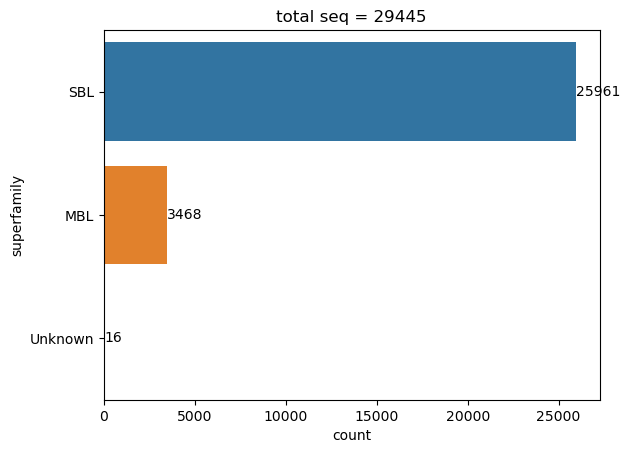

In [5]:
ax = sns.countplot(df, y="superfamily")
plt.title(f"total seq = {len(df)}")
ax.bar_label(ax.containers[0]);

In [6]:
# annot the families from headet info 
# inf comes from the BLDB Last updated: January 08, 2024
fam_a = [
    "AAK", "ACI", "AER", "AFA", "R39", "ARL", "AST", "ASU1", "AXC", "BBI", 
    "BcI", "BcIII", "BCL", "BEL", "BES", "BIC", "BKC", "BlaC", "BlaP", "BlaS", 
    "BOR", "BPA", "BRO", "CAD", "CAE", "CARB", "CblA", "CBP", "CdiA", "CepA", 
    "CfxA", "SegacoprA", "CGA", "CIA", "CKA", "CKO", "CM1", "CME", "CRP", "CRH", 
    "CSP", "CTX-M", "CumA", "CzoA", "CPA", "DBA", "DES", "ERP", "FAR", "FEC", "FLC", 
    "FONA", "FPH", "FRI", "FTU", "GES", "GIL", "GMA", "GPA", "GPC", "GRI", "HBL", 
    "HER", "HMS", "IMI", "KBL", "KLUA", "KLUB", "KLUC", "KLUG", "KLUS", "KLUY", 
    "KPC", "L2", "LAP", "LEN", "LUS", "LUT", "MAB", "MFO", "MIA", "MIN", "MM3", 
    "MOM", "MUN", "NLA", "NmcA", "OHIO", "OIH", "OKP", "ORF6", "ORN", "OXY", 
    "PAD", "PAL", "PAU", "PbbA", "PC1", "PC2", "PEC", "PenA", "PenB", "PenBcc", 
    "PenE", "PenF", "PenG", "PenH", "PenI", "PenJ", "PenL", "PenN", "PenO", "PER", 
    "PLA", "PLES", "PME", "PSV", "RAA", "RAHN", "RASA", "RATA", "RCP", "REUT", "RIC", 
    "ROB", "RSA1", "RSA2", "RUB", "SDA", "SCO", "SED", "SFC", "SGM", "SHV", "SME", 
    "SMO", "TEM", "TER", "TLA", "TLA2", "VAN", "VBR", "VEB", "VDA", "VCC", "VRB", "XCC", "BlaA"]

fam_b1 = ["AFM", "ANA", "BcII", "BIM", "BlaB", "CAM", "CfiA", "CGB", "CHM", "CEMC19", 
         "CrxA", "CX1", "DIM", "EBR", "ECV", "ElBla2", "FIA", "FIM", "GIM", "GMB", "GRD23", 
         "HBA", "HMB", "IMP", "IND", "JOHN", "KHM", "MOC", "MUS", "MYO", "MYX", "NDM", "ORR", 
         "PAN", "PEDO", "PKB", "PST", "SFB", "SHD", "SHN", "SIM", "SLB", "SPM", "SPN79", "SPS", 
         "STA", "SZM", "TTU", "TMB", "TUS", "VAM", "VIM", "VMB", "VMH", "WUS", "ZHO", "ZOG"]

fam_b2 = ["CphA", "CVI", "PFM", "SFH", "YEM"]

fam_b3 = ["AIM", "ALG6", "ALG11", "AM1", "BJP", "BLEG", "CAR", "CAU", "CHI",
         "CPS", "CRD3", "CSR", "DHT2", "EAM", "ECM", "EFM", "ELM", "ESP", "EVM", 
         "FEZ", "GOB", "L1", "LMB", "LRA2", "LRA3", "LRA7", "LRA8", "LRA12", "LRA17", 
         "LRA19", "MEMA1", "MIM", "MSI", "NWM", "PAM", "PEDO", "PJM", "PLN", "POM", "PNGM", 
         "RM3", "SAM", "SER", "SIE", "SIQ", "SMB", "SPG", "SPR", "SSE", "B3SU1", "B3SU2", "THIN"]

fam_c = ["ACC", "ACT", "ADC", "AMZ", "ASA3", "AQU", "AsbA1", "BUT", "CAV", "CDA", "CepH",
         "CepS", "CFE", "CHR", "CMA", "CMH", "CMY", "CSA", "DHA", "Ear", "EDC", "ERH", "EC", 
         "FOX", "IDC", "INQ", "LAQ", "LAT", "LHK", "LRA10", "LRA18", "LYL", "MIR", "MOR", "MOX", 
         "MYCC1", "OCH", "PAC", "PDC", "PFL", "PLY", "PRC", "PSZ", "RSC1", "RHO", "SFDC", "SGC", 
         "SLC", "SPC", "SRT", "SST", "SUC", "TRU", "UCB", "YEC", "YOC", "YRC", "MCA"]

fam_d = ["AFD", "ATD", "BAD", "BAT", "BED", "BEN", "BOC", "BPU", "BSD", "BSU", "CDD", "CEMC18", 
         "CPD", "LCR", "NOD", "NPS", "OXA", "RAD", "RSD1", "RSD2", "STD"]

fams = fam_a + fam_c + fam_c + fam_b1 + fam_b2 + fam_b3

print(f"class a  = {len(fam_a)}")
print(f"class c  = {len(fam_c)}")
print(f"class d  = {len(fam_d)}")
print(f"class b1 = {len(fam_b1)}")
print(f"class b2 = {len(fam_b2)}")
print(f"class b3 = {len(fam_b3)}")
print(f"Total    = {len(fams)}")

# a fx to retreive each fam from headers
def fam_annot(df, fams): 

    # enlist know fams into rx object
    valid = set(fams)
    rx="|".join(valid)

    # match fams
    match = 0
    mismatch = 0
    clss = []
    for values in df["#name"]:
        
        # tmp1: text of 2nd to last pipe
        try:
            tmp1 = re.search(r'\|\s*([^\|\s]+)\s*\|[^\|]*$', values).group(1)
        except:
            print(values)
            clss.append("Unknown")
            continue
        
        # tmp2: match vs rx list
        tmp2 = re.match(f"({rx})\-", tmp1)
        if tmp2:
            clss.append(tmp2.group(1))
            match +=1
        else:
            clss.append("Unknown")
            mismatch +=1

    # count annots and add clss list as a col
    print(f" Recognized families:{match}, Unknown:{mismatch}")
    df["protein_family"] = clss

# split the data by bla_class to annot
df_a  = df[df.bla_class == "class_a"]
df_c  = df[df.bla_class == "class_c"]
df_d  = df[df.bla_class == "class_d"]
df_b1 = df[df.bla_class == "class_b1"]
df_b2 = df[df.bla_class == "class_b2"]
df_b3 = df[df.bla_class == "class_b3"]
df_ot = df[df.bla_class == "other"]

# annot
fam_annot(df_a, fam_a)
fam_annot(df_c, fam_c)
fam_annot(df_d, fam_d)
fam_annot(df_b1, fam_b1)
fam_annot(df_b2, fam_b2)
fam_annot(df_b3, fam_b3)

class a  = 148
class c  = 58
class d  = 21
class b1 = 57
class b2 = 5
class b3 = 52
Total    = 378
EXU79044.1 beta-lactamase [Comamonas aquatica DA1877]
QPO64315.1 CTX-M family class A extended-spectrum beta-lactamase (plasmid) [Enterobacter hormaechei]
OKP13200.1|OKP-B-232 OKP family class A broad-spectrum beta-lactamase
 Recognized families:5859, Unknown:8805
 Recognized families:4518, Unknown:2240
 Recognized families:4449, Unknown:87
 Recognized families:688, Unknown:575
 Recognized families:454, Unknown:28
 Recognized families:643, Unknown:1080


/tmp/ipykernel_38518/2659424879.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["protein_family"] = clss
/tmp/ipykernel_38518/2659424879.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["protein_family"] = clss
/tmp/ipykernel_38518/2659424879.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

In [7]:
# look at the 3 cases that has an error in their annots
df_a[df_a["#name"].str.contains("EXU79044.1|QPO64315.1|OKP13200.1")]

,#name,seq,length,filename,bla_class,protein_name,protein_family_filename,superfamily,protein_family
9558,EXU79044.1 beta-lactamase [Comamonas aquatica ...,MQRRQFSLGLAWTTIGSLAGCAAGPSAAAKTERHWSQAMAQIEQDA...,301,A-CAE-T1-prot.fasta,class_a,CAE-T1,CAE,SBL,Unknown
10473,QPO64315.1 CTX-M family class A extended-spect...,MVKKSLRQFTLMATATVTLLLGSVPLYAQTADVQQKLAELERQSGG...,291,A-CTX-M-T269-prot.fasta,class_a,CTX-M-T269,CTX-M,SBL,Unknown
12133,OKP13200.1|OKP-B-232 OKP family class A broad-...,MRYVRLCLISLIAALPLAVFASPQPLEQIKISEGQLAGRVGYVEMD...,286,A-OKP-B-32-prot.fasta,class_a,OKP-B-32,OKP-B,SBL,Unknown


In [8]:
# the error comes from the lack of a | that indicate the family positions
for idx in [9558, 10473,12133]:
    print(df_a.loc[idx, "#name"])

EXU79044.1 beta-lactamase [Comamonas aquatica DA1877]
QPO64315.1 CTX-M family class A extended-spectrum beta-lactamase (plasmid) [Enterobacter hormaechei]
OKP13200.1|OKP-B-232 OKP family class A broad-spectrum beta-lactamase


In [9]:
# correct it 
df_a.loc[df_a['#name'].str.contains('EXU79044.1'), 'protein_family'] = 'Unknown'
df_a.loc[df_a['#name'].str.contains('QPO64315.1'), 'protein_family'] = 'CTX-M'
df_a.loc[df_a['#name'].str.contains('OKP13200.1'), 'protein_family'] = 'OKP'

df_a[df_a["#name"].str.contains("EXU79044.1|QPO64315.1|OKP13200.1")]

,#name,seq,length,filename,bla_class,protein_name,protein_family_filename,superfamily,protein_family
9558,EXU79044.1 beta-lactamase [Comamonas aquatica ...,MQRRQFSLGLAWTTIGSLAGCAAGPSAAAKTERHWSQAMAQIEQDA...,301,A-CAE-T1-prot.fasta,class_a,CAE-T1,CAE,SBL,Unknown
10473,QPO64315.1 CTX-M family class A extended-spect...,MVKKSLRQFTLMATATVTLLLGSVPLYAQTADVQQKLAELERQSGG...,291,A-CTX-M-T269-prot.fasta,class_a,CTX-M-T269,CTX-M,SBL,CTX-M
12133,OKP13200.1|OKP-B-232 OKP family class A broad-...,MRYVRLCLISLIAALPLAVFASPQPLEQIKISEGQLAGRVGYVEMD...,286,A-OKP-B-32-prot.fasta,class_a,OKP-B-32,OKP-B,SBL,OKP


In [10]:
# add the fam col and check the annots for the seqs labeled as other 
df_ot["protein_family"] = "Unknown"
df_ot

/tmp/ipykernel_38518/47063988.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ot["protein_family"] = "Unknown"


,#name,seq,length,filename,bla_class,protein_name,protein_family_filename,superfamily,protein_family
29429,OEZ55387.1|CD1-1| beta-lactamase [Duganella sp...,MNFRHIILGALASLVPISAAHATEVCTALADSNGPTLFQRGDCQRQ...,619,CD-CD1-1-prot.fasta,other,CD-CD1-1,CD-CD1,Unknown,Unknown
29430,ELX10257.1|CD1-2| beta-lactamase AmpC [Janthin...,MNFRHIILGALASLVPTSAAHATEVCTALADSNGPTLFQRGDCQRQ...,619,CD-CD1-2-prot.fasta,other,CD-CD1-2,CD-CD1,Unknown,Unknown
29431,WP_082565248.1|CD2-1| class C beta-lactamase,MADAATGKWLVLEGVCDKRLPPMSTFKLPIALMGYDAGVLWNEHAP...,571,CD-CD2-1-prot.fasta,other,CD-CD2-1,CD-CD2,Unknown,Unknown
29432,SFG43659.1|CD3-1| Beta-lactamase class D [Duga...,MKRKIFALLAGLGLPLLAFSAEHCLAMADAATGKWLVHEGVCDKRL...,597,CD-CD3-1-prot.fasta,other,CD-CD3-1,CD-CD3,Unknown,Unknown
29433,WP_082591432.1|CD4-1| class C beta-lactamase,MKRKIFALLAGLGLPLLAYSAEHCLAMADAASGKWLAHDGVCDKRL...,597,CD-CD4-1-prot.fasta,other,CD-CD4-1,CD-CD4,Unknown,Unknown
29434,WP_082507116.1|CD4-2| class C beta-lactamase,MKRKIFALLAGLGLPLLAYSAEHCLAMADAASGKWLAHDGVCDKRL...,597,CD-CD4-2-prot.fasta,other,CD-CD4-2,CD-CD4,Unknown,Unknown
29435,SHH20105.1|CD5-1| Beta-lactamase class D [Mass...,MTFRMTAMAVVGAVAALVAAPALHAAEICTAIADAATGKVLMQRGD...,614,CD-CD5-1-prot.fasta,other,CD-CD5-1,CD-CD5,Unknown,Unknown
29436,WP_082552146.1|CD6-1| class C beta-lactamase,MMVMFVAFRGFERRSMKFRMIAMAALGSVAALAAVPAACAAEVCTA...,637,CD-CD6-1-prot.fasta,other,CD-CD6-1,CD-CD6,Unknown,Unknown
29437,KQW93884.1|CD7-1| hypothetical protein ASC94_1...,MIAMAALGCVAGLAGVPAHGAEICTAIADAATGKVLMQRGDCQRQV...,621,CD-CD7-1-prot.fasta,other,CD-CD7-1,CD-CD7,Unknown,Unknown
29438,ACH58991.1|LRA13-1| bifunctional class C beta-...,MNFRHIVMAALCGLAWTPAIHATEVCIAIAEAGTGAVLVQRGDCQR...,609,CD-LRA13-1-prot.fasta,other,CD-LRA13-1,CD-LRA13,Unknown,Unknown


/tmp/ipykernel_38518/3600688938.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_["top_fam"] = df_["protein_family"].apply(lambda x: x if x in top else "No top")
/tmp/ipykernel_38518/3600688938.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_["top_fam"] = df_["protein_family"].apply(lambda x: x if x in top else "No top")
/tmp/ipykernel_38518/3600688938.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

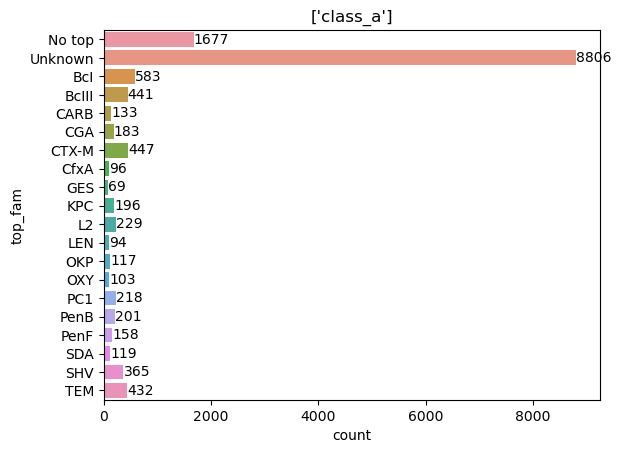

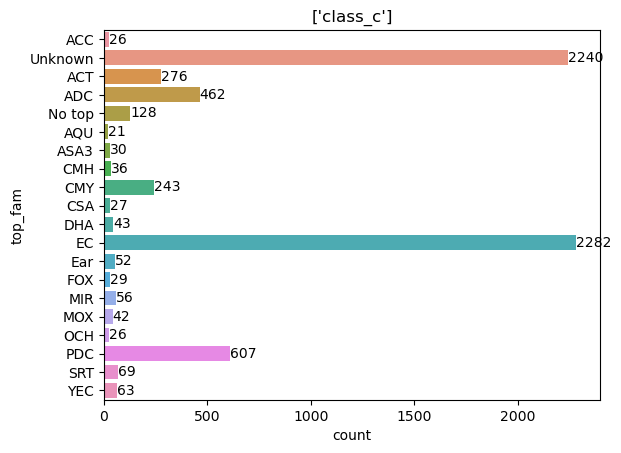

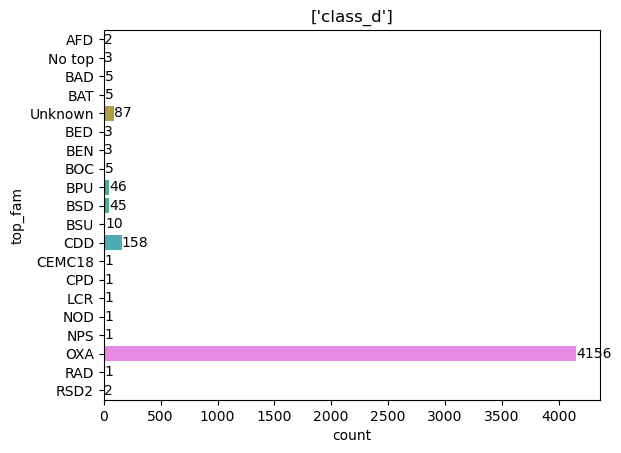

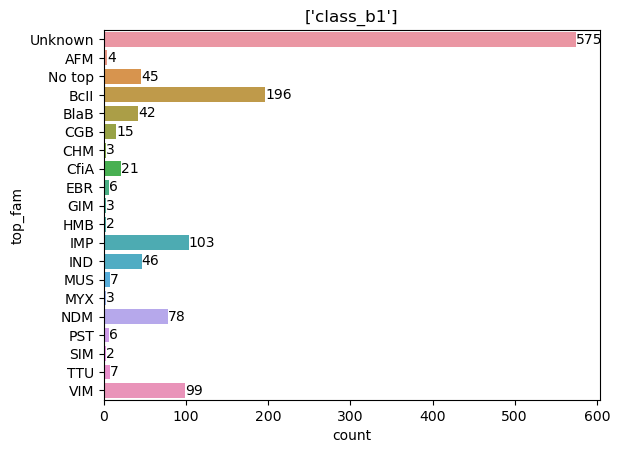

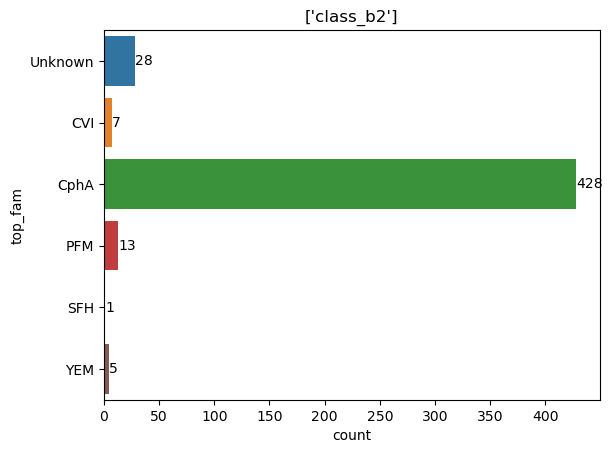

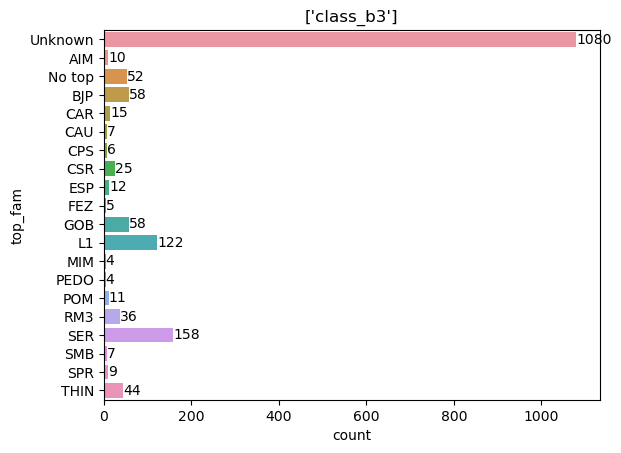

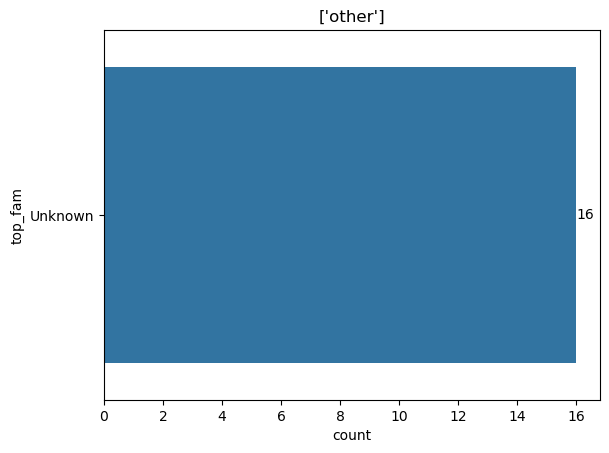

In [11]:
# a fx to getr the top 19 fams
def get_top_fams(df_):

    top = df_["protein_family"].value_counts().nlargest(19).index
    df_["top_fam"] = df_["protein_family"].apply(lambda x: x if x in top else "No top")
    
    return df_

#annots
df_a  = get_top_fams(df_a)
df_c  = get_top_fams(df_c)
df_d  = get_top_fams(df_d)
df_b1 = get_top_fams(df_b1)
df_b2 = get_top_fams(df_b2)
df_b3 = get_top_fams(df_b3)
df_ot = get_top_fams(df_ot)


bla_dfs = [df_a, df_c, df_d, df_b1, df_b2, df_b3, df_ot]

# plots
for dset in bla_dfs:
    ax = sns.countplot(dset, y="top_fam")
    plt.title(f"{dset.bla_class.unique()}")
    ax.bar_label(ax.containers[0])
    plt.show();

In [12]:
# create an idx
df = pd.concat(bla_dfs, ignore_index=True)
df["seq_id"] = "bldb_" + (df.index + 1).astype(str).str.zfill(6)
df

,#name,seq,length,filename,bla_class,protein_name,protein_family_filename,superfamily,protein_family,top_fam,seq_id
0,QOI11476.1|AAK-1| class A beta-lactamase AAK-1,MRYIRLCIISLFATLPLAVHASPQPLQQITLRESQLSGRVGTIEMD...,286,A-AAK-1-prot.fasta,class_a,AAK-1,AAK,SBL,AAK,No top,bldb_000001
1,gi|5596421|emb|CAB51471.1|ACI-1| class A exten...,MKKFCFLFLIICGLMVFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-1-prot.fasta,class_a,ACI-1,ACI,SBL,ACI,No top,bldb_000002
2,WP_247239681.1|ACI-10| ACI family class A beta...,MKKFCFLFLIICGLMVFCPQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-10-prot.fasta,class_a,ACI-10,ACI,SBL,ACI,No top,bldb_000003
3,WP_296333831.1|ACI-11| ACI family class A beta...,MKKFCFLFLIICGLMVFCPQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-11-prot.fasta,class_a,ACI-11,ACI,SBL,ACI,No top,bldb_000004
4,WP_279133745.1|ACI-12| ACI family class A beta...,MKKFCFLFLIICGLMVFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-12-prot.fasta,class_a,ACI-12,ACI,SBL,ACI,No top,bldb_000005
...,...,...,...,...,...,...,...,...,...,...,...
29440,WP_019923896.1|XD-XD1-1| Duganella zoogloeoide...,MMPIDLDIVLARLLLAAAGSLAAGGAVWAVAVLCRRTLPALAQQRS...,631,XD-XD1-1-prot.fasta,other,XD-XD1-1,XD-XD1,Unknown,Unknown,Unknown,bldb_029441
29441,KQN73069.1|XD-XD1-2| Duganella sp. Leaf61,MMPIDLDIVLARLLLAAAGSLAAGGAVWAVAVLCRRTLPALAQQRS...,631,XD-XD1-2-prot.fasta,other,XD-XD1-2,XD-XD1,Unknown,Unknown,Unknown,bldb_029442
29442,OFA09008.1|XD-XD1-3| Duganella phyllosphaerae,MMPIDLDVVLARLLLAAAGSLAAGGAVWAVAVLCRRTLPALAQQRS...,632,XD-XD1-3-prot.fasta,other,XD-XD1-3,XD-XD1,Unknown,Unknown,Unknown,bldb_029443
29443,SHM90367.1|XD-XD2-1| Duganella sacchari,MTGFDIALVRLLLAAAGSLAAGGAVWGVALLCRRYLPALAQHRSLW...,597,XD-XD2-1-prot.fasta,other,XD-XD2-1,XD-XD2,Unknown,Unknown,Unknown,bldb_029444


In [13]:
# get the protein names 
original_protein_names = df.protein_name.to_list()

# load annots from bldb
df_annots = pd.read_csv("../bldb/annots/bldb_annotations.csv")
df_annots["pdb_structures"].fillna(0, inplace=True) # due to a problem to export as parquet
df_annots["mutants"].fillna(0, inplace=True) # due to a problem to export as parquet

df_annots.fillna("unknown", inplace=True)

# reformat strings
df["protein_name"] = df["protein_name"].str.lower()
df_annots["protein_name"] = df_annots["protein_name"].str.lower()

# merge dsets and add original names
df = df.merge(df_annots, on="protein_name", how="left")
df["protein_name"] = original_protein_names
df

,#name,seq,length,filename,bla_class,protein_name,protein_family_filename,superfamily,protein_family,top_fam,...,subfamily,genpept_id,genbank_id,pubmed_id,seq_url,pdb_structures,mutants,phenotype,functional_info,source
0,QOI11476.1|AAK-1| class A beta-lactamase AAK-1,MRYIRLCIISLFATLPLAVHASPQPLQQITLRESQLSGRVGTIEMD...,286,A-AAK-1-prot.fasta,class_a,AAK-1,AAK,SBL,AAK,No top,...,SHV-like,QOI11476,MW042819,unknown,view,0.0,0.0,unknown,unknown,N (Klebsiella pneumoniae ABHI1)
1,gi|5596421|emb|CAB51471.1|ACI-1| class A exten...,MKKFCFLFLIICGLMVFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-1-prot.fasta,class_a,ACI-1,ACI,SBL,ACI,No top,...,unknown,CAB51471,AJ007350,11036038 (DOI),view,0.0,0.0,unknown,ESBL,N (Acidaminococcus fermentans)
2,WP_247239681.1|ACI-10| ACI family class A beta...,MKKFCFLFLIICGLMVFCPQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-10-prot.fasta,class_a,ACI-10,ACI,SBL,ACI,No top,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,WP_296333831.1|ACI-11| ACI family class A beta...,MKKFCFLFLIICGLMVFCPQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-11-prot.fasta,class_a,ACI-11,ACI,SBL,ACI,No top,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,WP_279133745.1|ACI-12| ACI family class A beta...,MKKFCFLFLIICGLMVFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-12-prot.fasta,class_a,ACI-12,ACI,SBL,ACI,No top,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29440,WP_019923896.1|XD-XD1-1| Duganella zoogloeoide...,MMPIDLDIVLARLLLAAAGSLAAGGAVWAVAVLCRRTLPALAQQRS...,631,XD-XD1-1-prot.fasta,other,XD-XD1-1,XD-XD1,Unknown,Unknown,Unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29441,KQN73069.1|XD-XD1-2| Duganella sp. Leaf61,MMPIDLDIVLARLLLAAAGSLAAGGAVWAVAVLCRRTLPALAQQRS...,631,XD-XD1-2-prot.fasta,other,XD-XD1-2,XD-XD1,Unknown,Unknown,Unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29442,OFA09008.1|XD-XD1-3| Duganella phyllosphaerae,MMPIDLDVVLARLLLAAAGSLAAGGAVWAVAVLCRRTLPALAQQRS...,632,XD-XD1-3-prot.fasta,other,XD-XD1-3,XD-XD1,Unknown,Unknown,Unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29443,SHM90367.1|XD-XD2-1| Duganella sacchari,MTGFDIALVRLLLAAAGSLAAGGAVWGVALLCRRYLPALAQHRSLW...,597,XD-XD2-1-prot.fasta,other,XD-XD2-1,XD-XD2,Unknown,Unknown,Unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# load and add the gtdb taxonomy
diamond_cols = ["seq_id","bitscore","Domain","Phylum","Class","Order","Family","Genus","Species"]
df_tax = pd.read_csv("../bldb/annots/gtdb_R214_taxonomy_bldb.csv", sep = "\t", names = diamond_cols)
df_tax.fillna("Unknown", inplace=True) # fill nans 

df = df.merge(df_tax, on="seq_id", how="inner")
df["Domain"]  = df.Domain.str.replace("d__", "")
df["Phylum"]  = df.Phylum.str.replace("p__", "")
df["Class"]   = df.Class.str.replace("c__", "")
df["Order"]   = df.Order.str.replace("o__", "")
df["Family"]  = df.Family.str.replace("f__", "")
df["Genus"]   = df.Genus.str.replace("g__", "")
df["Species"] = df.Species.str.replace("s__", "")

df.bitscore.describe()

count    29445.000000
mean       598.404653
std        102.486425
min        130.000000
25%        540.000000
50%        574.000000
75%        647.000000
max       1573.000000
Name: bitscore, dtype: float64

# philippon

In [15]:
# representative fams from the supp mat. of philippon et al 2019

# missing: SPU
# Cbl in the paper is CblA in BLDB
rep_enz_a = [
    "PER","VEB","CSP","SPU","CME","CIA","CGA","TLA","TLA2","LUS","CfxA",
    "CepA", "CblA"]

# all matched
rep_enz_b = ["PME","SGM","GES","BEL"]

# missing: VHW MP RHOCA SEL PSE
# VHH in the paper is VDA in BLDB 
# AmpC is AKA EC in BLDB
# RTG in the paper is CARB in BLDB
# PSE also is CARB in BLDB
# OKP-A/B in the paper are only OKP in BLDB 
rep_enz_c = [
    "VDA","VHW","AmpC", "MP","RHOCA","LAP","SHV","OHIO","LEN",
    "OKP","TER","GIL","TEM", "RUB","RTG","SCO","SEL",
    "HER","PSE","AER", "CKO","MAL","PLES","CARB","PAL","HMS",
    "ORN", "KLUY", "FPH"]

# missing: BlaAZ BlaIII BlaY BlaF STRCE STRCL STRFR STRLA STRAL STRCAO STRCA
# BlaF in the paper is MFO in BLDB
# STRAL in the paper is SDA-A-1 in BLDB
rep_enz_d = [
    "CAD","BlaAZ", "ARL","ROB", "ACI","CBP","BCL","BlaIII","BlaP",
    "OIH","BlaY","BlaS","BlaF","STRCE", "STRCL","STRFR","STRLA",
    "STRAL","MAB","FAR","AST", "BlaC", "STRCAO","STRCA","R39", "MFO", "SDA"]

# no estan:  CRS YENT K1
rep_enz_e = [
    "FRI","VCC","IMI","NMCA","SME","SFC","BIC","CRS","CRH","CRP","KPC",
    "PenB","PenA","LUT","PenL","BPS","PenI","MIN","DES","BES","ERP",
    "YENT","HugA","CumA","SMO","RAHN","FONA","SFO","KLUC",
    "CTX-M","KLUA","KLUG","SED","RIC","GRI","K1","OXY"]

# all matched
rep_enz_f = [
    "XCC","BOR","AXC","PAD","BKC","GPC", "CzoA", "L2"]

# rep_enz_miss = [
#    'BcI', 'BRO', 'BBI', 'ASU1', 'BcIII', 'RPA', 'RSA1', 'RSA2', 
#    , 'FTU', 'GPA', 'RCP', 'FLC', 'FEC', 'DBA', 'PenP', 
#    'RAA', 'CST', 'CPA', 'CM1', 'CKA', 'VBR', 'CdiA', 'PC1', 
#    'PC2', 'PbbA', 'PSV', 'PLA', 'MIA', 'MM3', 'PAU', 'ORF6', 
#    'PenE', 'BlaA', 'AFA']
# rep_enz_x = ["BRO","FTU", "FPH"]

filters = [
    (df.protein_family.isin(rep_enz_a)) & (df.bla_class == "class_a"),
    (df.protein_family.isin(rep_enz_b)) & (df.bla_class == "class_a"),
    (df.protein_family.isin(rep_enz_c)) & (df.bla_class == "class_a"),
    (df.protein_family.isin(rep_enz_d)) & (df.bla_class == "class_a"),
    (df.protein_family.isin(rep_enz_e)) & (df.bla_class == "class_a"),
    (df.protein_family.isin(rep_enz_f)) & (df.bla_class == "class_a")
]

values = ["A", "B", "C", "D", "E", "F"]

#    "Group C (LSBL; limited-spectrum beta-lactamases)",
#    "Group D (Gram positive)",
#    "Group E (WSBL; wider spectrum betalactamases)",
#    "Group F (Gram negative rods)",
#    "Group A (Subclass A2)"
   
df["phylo_group"] = np.select(filters, values)
df.loc[df["phylo_group"] == "0", 'phylo_group'] = "Unknown"

#print info
for ele in df.phylo_group.unique():
    print(f"##### Philippon phylogenetic group = {ele} #####")
    print(f"number of families: {df[df.phylo_group == ele].protein_family.nunique()}")
    print(df[df.phylo_group == ele].protein_family.unique())

##### Philippon phylogenetic group = Unknown #####
number of families: 244
['AAK' 'AFA' 'Unknown' 'ASU1' 'BBI' 'BPA' 'BRO' 'BcI' 'BcIII' 'BlaA' 'CAE'
 'CKA' 'CM1' 'CPA' 'CdiA' 'DBA' 'FEC' 'FLC' 'FTU' 'GMA' 'GPA' 'HBL' 'KBL'
 'KLUB' 'KLUS' 'MIA' 'MM3' 'MOM' 'MUN' 'NLA' 'ORF6' 'PAU' 'PC1' 'PC2'
 'PEC' 'PLA' 'PSV' 'PbbA' 'PenBcc' 'PenE' 'PenF' 'PenG' 'PenH' 'PenJ'
 'PenN' 'PenO' 'RAA' 'RASA' 'RATA' 'RCP' 'RSA1' 'RSA2' 'SegacoprA' 'VBR'
 'ACC' 'ACT' 'ADC' 'AMZ' 'AQU' 'ASA3' 'AsbA1' 'BUT' 'CAV' 'CDA' 'CFE'
 'CHR' 'CMA' 'CMH' 'CMY' 'CSA' 'CepH' 'CepS' 'DHA' 'EC' 'EDC' 'ERH' 'Ear'
 'FOX' 'IDC' 'LAQ' 'LAT' 'LHK' 'LRA10' 'LRA18' 'LYL' 'MCA' 'MIR' 'MOR'
 'MOX' 'MYCC1' 'OCH' 'PAC' 'PDC' 'PFL' 'PLY' 'PRC' 'PSZ' 'RHO' 'RSC1'
 'SFDC' 'SGC' 'SLC' 'SPC' 'SRT' 'SST' 'SUC' 'TRU' 'UCB' 'YEC' 'YOC' 'YRC'
 'AFD' 'ATD' 'BAD' 'BAT' 'BED' 'BEN' 'BOC' 'BPU' 'BSD' 'BSU' 'CDD'
 'CEMC18' 'CPD' 'LCR' 'NOD' 'NPS' 'OXA' 'RAD' 'RSD1' 'RSD2' 'STD' 'AFM'
 'ANA' 'BIM' 'BcII' 'BlaB' 'CAM' 'CEMC19' 'CGB' 'CHM' 'CX1' 'CfiA

In [16]:
# load putative genus
df_phylo_genus = pd.read_csv("../bldb/annots/philippon_genus.csv")
df_phylo_genus.drop_duplicates(subset=["Genus"], inplace=True)
df_phylo_genus = df_phylo_genus.reset_index(drop=True)
df_phylo_genus

,Genus,phylo_group_genus
0,Prevotella,A
1,Bacteroides,A
2,Parabacteroides,A
3,Alistipes,A
4,Paraprevotella,A
...,...,...
267,Sorangium,F
268,Geothrix,F
269,Bordetella,F
270,Methyloligella,F


In [17]:
# load putative spp
df_phylo_sp = pd.read_csv("../bldb/annots/philippon_species.csv")
df_phylo_sp.drop_duplicates(subset=["Species"], inplace=True)
df_phylo_sp = df_phylo_sp.reset_index(drop=True)
df_phylo_sp

,Species,phylo_group_sp
0,Prevotella buccae,A
1,Prevotella intermedia,A
2,Prevotella oris,A
3,Prevotella melaninogenica,A
4,Prevotella denticola,A
...,...,...
545,Bordetella hinzii,F
546,Methyloligella halotolerans,F
547,Methyloceanibacter marginalis,F
548,Methyloceanibacter methanicus,F


In [18]:
# create lists for genus
genus_a = df_phylo_genus[df_phylo_genus.phylo_group_genus == "A"].Genus.to_list()
genus_b = df_phylo_genus[df_phylo_genus.phylo_group_genus == "B"].Genus.to_list()
genus_c = df_phylo_genus[df_phylo_genus.phylo_group_genus == "C"].Genus.to_list()
genus_d = df_phylo_genus[df_phylo_genus.phylo_group_genus == "D"].Genus.to_list()
genus_e = df_phylo_genus[df_phylo_genus.phylo_group_genus == "E"].Genus.to_list()
genus_f = df_phylo_genus[df_phylo_genus.phylo_group_genus == "F"].Genus.to_list()

print(f"Genus in group A = {len(genus_a)}")
print(f"Genus in group B = {len(genus_b)}")
print(f"Genus in group C = {len(genus_c)}")
print(f"Genus in group D = {len(genus_d)}")
print(f"Genus in group E = {len(genus_e)}")
print(f"Genus in group F = {len(genus_f)}")

# for spp
spp_a = df_phylo_sp[df_phylo_sp.phylo_group_sp == "A"].Species.to_list()
spp_b = df_phylo_sp[df_phylo_sp.phylo_group_sp == "B"].Species.to_list()
spp_c = df_phylo_sp[df_phylo_sp.phylo_group_sp == "C"].Species.to_list()
spp_d = df_phylo_sp[df_phylo_sp.phylo_group_sp == "D"].Species.to_list()
spp_e = df_phylo_sp[df_phylo_sp.phylo_group_sp == "E"].Species.to_list()
spp_f = df_phylo_sp[df_phylo_sp.phylo_group_sp == "F"].Species.to_list()

print(f"spp in group A = {len(spp_a)}")
print(f"spp in group B = {len(spp_b)}")
print(f"spp in group C = {len(spp_c)}")
print(f"spp in group D = {len(spp_d)}")
print(f"spp in group E = {len(spp_e)}")
print(f"spp in group F = {len(spp_f)}")

Genus in group A = 61
Genus in group B = 20
Genus in group C = 47
Genus in group D = 54
Genus in group E = 24
Genus in group F = 66
spp in group A = 106
spp in group B = 32
spp in group C = 90
spp in group D = 116
spp in group E = 55
spp in group F = 151


In [19]:
# for genus 
filters2 = [
    (df.Genus.isin(genus_a)) & (df.bla_class == "class_a"),
    (df.Genus.isin(genus_b)) & (df.bla_class == "class_a"),
    (df.Genus.isin(genus_c)) & (df.bla_class == "class_a"),
    (df.Genus.isin(genus_d)) & (df.bla_class == "class_a"),
    (df.Genus.isin(genus_e)) & (df.bla_class == "class_a"),
    (df.Genus.isin(genus_f)) & (df.bla_class == "class_a")]

values2 = ["A", "B", "C", "D", "E", "F"]

df["phylo_group_genus"] = np.select(filters2, values2)
df["phylo_group_genus"] = df["phylo_group_genus"].str.replace("0","Unknown")

# for genus 
filters3 = [
    (df.Species.isin(spp_a)) & (df.bla_class == "class_a"),
    (df.Species.isin(spp_b)) & (df.bla_class == "class_a"),
    (df.Species.isin(spp_c)) & (df.bla_class == "class_a"),
    (df.Species.isin(spp_d)) & (df.bla_class == "class_a"),
    (df.Species.isin(spp_e)) & (df.bla_class == "class_a"),
    (df.Species.isin(spp_f)) & (df.bla_class == "class_a")]

values3 = ["A", "B", "C", "D", "E", "F"]

df["phylo_group_sp"] = np.select(filters3, values3)
df["phylo_group_sp"] = df["phylo_group_sp"].str.replace("0","Unknown")

# subclass

in  the paper [Class C b-Lactamases: Molecular Characteristics](https://pubmed.ncbi.nlm.nih.gov/35435729/) say :

"the identification of a tiny, phylogenetically distant cluster (including enzymes from the genera Legionella, Bradyrhizobium, and Parachlamydia) has raised questions about the possible existence of a C2 subclass of b-lactamases, previously identified as serine hydrolases"

Also the phylo group A in class A [correspond to sublcass A2](https://pubmed.ncbi.nlm.nih.gov/31155436/) 

In [20]:
a1_group = ["B","C","D","E","F"]
c2_genus = ["Legionella", "Bradyrhizobium", "Parachlamydia"]
c1_rep_fams = [
    "ACC","ACT","ABA","ABAC","ADC","AQU","AsbA","BIL", "CMY", "BlaE","BUT",
    "CAV","CDA","CepH","CepS","CFE","CHR","CMA","CMH","CMY","CSA","DHA","Ear",
    "EDC","ENT","ERH","FOX","IDC","EC","LAT","LHK","LRA10","LRA18","LYL","MIR",
    "MOX","OCH", "PDC","PAC","SLC","PSI","RHO","SST","TRU","YEC","YRC"] # table 2 from the paper

# a fx to annot subclasses
def annot_subclas(row):
    if row["phylo_group"] == "A" and row["bla_class"] == "class_a":
        return "A2"
    elif row["phylo_group"] in a1_group and row["bla_class"] == "class_a":
        return "A1"
    elif row["bla_class"] == "class_c" and row["Genus"] in c2_genus:
        return "C2"
    elif row["bla_class"] == "class_c" and row["Genus"] in c1_rep_fams:
        return "C1"
    else:
        return "Unknown"

# annot
df["bla_subclass"] = df.apply(annot_subclas, axis=1)

# load embeddings

In [21]:
# split dset 
df_bla_a  = df[df.bla_class == "class_a"]
df_bla_c  = df[df.bla_class == "class_c"]
df_bla_d  = df[df.bla_class == "class_d"]
df_bla_b1 = df[df.bla_class == "class_b1"]
df_bla_b2 = df[df.bla_class == "class_b2"]
df_bla_b3 = df[df.bla_class == "class_b3"]
df_bla_ot = df[df.bla_class == "other"]

# a fx to export fasta seqs
def export_fasta(df, output_file):
    with open(output_file, 'w') as f:
        for index, row in df.iterrows():
            f.write(f'>{row["seq_id"]}\n')
            f.write(f'{row["seq"]}\n')
 
export_fasta(df,        "../bldb/clean/fasta/bldb.fasta")
export_fasta(df_bla_a,  "../bldb/clean/fasta/bldb_a.fasta")
export_fasta(df_bla_d,  "../bldb/clean/fasta/bldb_c.fasta")
export_fasta(df_bla_c,  "../bldb/clean/fasta/bldb_d.fasta")
export_fasta(df_bla_b1, "../bldb/clean/fasta/bldb_b1.fasta")
export_fasta(df_bla_b2, "../bldb/clean/fasta/bldb_b2.fasta")
export_fasta(df_bla_b3, "../bldb/clean/fasta/bldb_b3.fasta")
export_fasta(df_bla_ot, "../bldb/clean/fasta/bldb_ot.fasta")

Go to the notebook "bldb_embeddings" for more details of the creation of the embeddings

In [22]:
# generate the embeddings from the final layer of each model 
# using the extract script for each repo 
df_plm = pd.read_parquet("../bldb/embeddings/all_plm.parquet")

# merge dsets
df = df.merge(df_plm, on="seq_id", how="inner")
df

,#name,seq,length,filename,bla_class,protein_name,protein_family_filename,superfamily,protein_family,top_fam,...,Species,phylo_group,phylo_group_genus,phylo_group_sp,bla_subclass,esm1b,esm2_650m,esm2_3b,carp,t5xlu50
0,QOI11476.1|AAK-1| class A beta-lactamase AAK-1,MRYIRLCIISLFATLPLAVHASPQPLQQITLRESQLSGRVGTIEMD...,286,A-AAK-1-prot.fasta,class_a,AAK-1,AAK,SBL,AAK,No top,...,Unknown,Unknown,Unknown,Unknown,Unknown,"[0.12652979791164398, -0.027409343048930168, -...","[0.0518777035176754, -0.061942994594573975, 0....","[-0.05046926811337471, 0.056019604206085205, 0...","[8.478848, 3.0101824, 1.0903528, 1.4809462, 0....","[0.027952505, 0.085560836, 0.04108497, 0.03436..."
1,gi|5596421|emb|CAB51471.1|ACI-1| class A exten...,MKKFCFLFLIICGLMVFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-1-prot.fasta,class_a,ACI-1,ACI,SBL,ACI,No top,...,Unknown,D,Unknown,Unknown,A1,"[0.11033030599355698, 0.014744792133569717, -0...","[0.04711497947573662, -0.02200073003768921, -0...","[-0.01986880414187908, 0.021787242963910103, 0...","[8.336181, 1.0826874, 1.1652166, 1.2500206, -0...","[0.008963341, 0.026664956, 0.024013866, 0.0149..."
2,WP_247239681.1|ACI-10| ACI family class A beta...,MKKFCFLFLIICGLMVFCPQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-10-prot.fasta,class_a,ACI-10,ACI,SBL,ACI,No top,...,Unknown,D,Unknown,Unknown,A1,"[0.10589545965194702, 0.018104366958141327, -0...","[0.045687928795814514, -0.01693999581038952, -...","[-0.024790115654468536, 0.024141503497958183, ...","[8.301235, 1.0443584, 1.2274909, 1.2571654, -0...","[0.0115642445, 0.026865002, 0.02342299, 0.0117..."
3,WP_296333831.1|ACI-11| ACI family class A beta...,MKKFCFLFLIICGLMVFCPQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-11-prot.fasta,class_a,ACI-11,ACI,SBL,ACI,No top,...,Unknown,D,Unknown,Unknown,A1,"[0.1069338470697403, 0.01760653406381607, -0.1...","[0.046535491943359375, -0.016012685373425484, ...","[-0.024704933166503906, 0.02391102723777294, 0...","[8.306835, 1.0323696, 1.2415323, 1.2548839, -0...","[0.01113927, 0.02677814, 0.023243126, 0.011637..."
4,WP_279133745.1|ACI-12| ACI family class A beta...,MKKFCFLFLIICGLMVFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-12-prot.fasta,class_a,ACI-12,ACI,SBL,ACI,No top,...,Unknown,D,Unknown,Unknown,A1,"[0.11295679956674576, 0.01596277579665184, -0....","[0.04823942109942436, -0.02260952815413475, -0...","[-0.021446440368890762, 0.0231647752225399, 0....","[8.310698, 0.9825358, 1.2005272, 1.2062249, -0...","[0.009067953, 0.02599874, 0.024248153, 0.01407..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29440,WP_019923896.1|XD-XD1-1| Duganella zoogloeoide...,MMPIDLDIVLARLLLAAAGSLAAGGAVWAVAVLCRRTLPALAQQRS...,631,XD-XD1-1-prot.fasta,other,XD-XD1-1,XD-XD1,Unknown,Unknown,Unknown,...,Duganella zoogloeoides,Unknown,Unknown,Unknown,Unknown,"[0.10123515874147415, 0.11845904588699341, 0.0...","[0.043884459882974625, -0.047707699239254, 0.0...","[0.013168132863938808, 0.027006611227989197, 0...","[5.389941, 1.7927954, 1.7919815, -0.30809766, ...","[-0.041473094, -0.023145743, 0.013129777, 0.06..."
29441,KQN73069.1|XD-XD1-2| Duganella sp. Leaf61,MMPIDLDIVLARLLLAAAGSLAAGGAVWAVAVLCRRTLPALAQQRS...,631,XD-XD1-2-prot.fasta,other,XD-XD1-2,XD-XD1,Unknown,Unknown,Unknown,...,Duganella zoogloeoides,Unknown,Unknown,Unknown,Unknown,"[0.10570667684078217, 0.11156294494867325, 0.0...","[0.04070212319493294, -0.04019564762711525, 0....","[0.014155537821352482, 0.021809358149766922, 0...","[5.40557, 2.1700292, 1.8351994, -0.24209538, 1...","[-0.044912886, -0.016441422, 0.009251282, 0.06..."
29442,OFA09008.1|XD-XD1-3| Duganella phyllosphaerae,MMPIDLDVVLARLLLAAAGSLAAGGAVWAVAVLCRRTLPALAQQRS...,632,XD-XD1-3-prot.fasta,other,XD-XD1-3,XD-XD1,Unknown,Unknown,Unknown,...,Duganella phyllosphaerae,Unknown,Unknown,Unknown,Unknown,"[0.09648735076189041, 0.10834503173828125, 0.0...","[0.0388491153717041, -0.049378931522369385, 0....","[0.018901925534009933, 0.01777895726263523, 0....","[5.4345202, 1.9380586, 1.6966496, -0.17246045,...","[-0

# biopython annots

total natural seqs = 29396


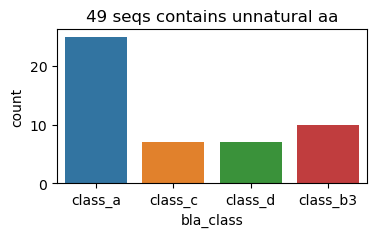

In [23]:
# get seqs that contains unnatural aa
df_no_nat = df[df["seq"].apply(lambda x: not remove_unnatural(x))]

plt.figure(figsize=(4,2))
sns.countplot(x = df_no_nat.bla_class)
plt.title(f"{len(df_no_nat)} seqs contains unnatural aa")

# remove seqs with unnat aa
df_nat = df[~df.index.isin(df_no_nat.index)]
nat_seqs = df_nat["seq"].to_list()
print(f"total natural seqs = {len(nat_seqs)}")

In [24]:
# empty lists
lst_molecular_weight  = []
lst_aromaticity       = []
lst_instability       = []
lst_gravy             = []
lst_isoelectric_point = []
lst_entropy           = []
lst_second_structure  = []


# calculate props 
for seq in nat_seqs:
    
    # molecular weight
    molecular_weight = ProteinAnalysis(seq).molecular_weight()
    lst_molecular_weight.append(molecular_weight)
    
    # aromaticity
    aromaticity = ProteinAnalysis(seq).aromaticity()
    lst_aromaticity.append(aromaticity)
    
    # instability
    instability = ProteinAnalysis(seq).instability_index()
    lst_instability.append(instability)
    
    # gravy
    gravy = ProteinAnalysis(seq).gravy()
    lst_gravy.append(gravy)
    
    # isoelectric_point
    isoelectric_point = ProteinAnalysis(seq).isoelectric_point()
    lst_isoelectric_point.append(isoelectric_point)
    
    # entropy
    entropy_val = entropy(seq)
    lst_entropy.append(entropy_val)
    
    # lst_second_structure | helix: V, I, Y, F, W, L | Turn: N, P, G, S | sheet: E, M, A, L
    second_structure = ProteinAnalysis(seq).secondary_structure_fraction()
    lst_second_structure.append(second_structure)

# create cols
df_nat["molecular_weight"]  = lst_molecular_weight
df_nat["aromaticity"]       = lst_aromaticity
df_nat["instability"]       = lst_instability
df_nat["gravy"]             = lst_gravy
df_nat["isoelectric_point"] = lst_isoelectric_point
df_nat["entropy"]           = lst_entropy
df_nat["second_structure"]  = lst_second_structure

# split second_structure
df_nat[["helix","turn","sheet"]] = pd.DataFrame(df_nat['second_structure'].tolist(), index = df_nat.index)
df_nat.drop("second_structure", axis=1, inplace=True)

# add the cols to the df_no_nat and fill it with nans
extra_cols = ['molecular_weight', 'aromaticity', 'instability', 'gravy',
                 'isoelectric_point', 'entropy', 'helix', 'turn', 'sheet']

for col in extra_cols:
    df_no_nat.loc[:, col] = np.nan

# concat dfs
df = pd.concat([df_nat, df_no_nat], ignore_index=True)
df = df.sort_values(by="seq_id")
df

/tmp/ipykernel_38518/1245498236.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nat["molecular_weight"]  = lst_molecular_weight
/tmp/ipykernel_38518/1245498236.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nat["aromaticity"]       = lst_aromaticity
/tmp/ipykernel_38518/1245498236.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

,#name,seq,length,filename,bla_class,protein_name,protein_family_filename,superfamily,protein_family,top_fam,...,t5xlu50,molecular_weight,aromaticity,instability,gravy,isoelectric_point,entropy,helix,turn,sheet
0,QOI11476.1|AAK-1| class A beta-lactamase AAK-1,MRYIRLCIISLFATLPLAVHASPQPLQQITLRESQLSGRVGTIEMD...,286,A-AAK-1-prot.fasta,class_a,AAK-1,AAK,SBL,AAK,No top,...,"[0.027952505, 0.085560836, 0.04108497, 0.03436...",31272.6686,0.052448,38.743007,-0.025874,9.175737,3.999562,0.293706,0.185315,0.321678
1,gi|5596421|emb|CAB51471.1|ACI-1| class A exten...,MKKFCFLFLIICGLMVFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-1-prot.fasta,class_a,ACI-1,ACI,SBL,ACI,No top,...,"[0.008963341, 0.026664956, 0.024013866, 0.0149...",32041.5642,0.080986,33.895775,-0.316901,8.350993,4.124073,0.295775,0.204225,0.246479
2,WP_247239681.1|ACI-10| ACI family class A beta...,MKKFCFLFLIICGLMVFCPQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-10-prot.fasta,class_a,ACI-10,ACI,SBL,ACI,No top,...,"[0.0115642445, 0.026865002, 0.02342299, 0.0117...",32037.5755,0.080986,35.272183,-0.317606,8.350993,4.125713,0.295775,0.207746,0.242958
3,WP_296333831.1|ACI-11| ACI family class A beta...,MKKFCFLFLIICGLMVFCPQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-11-prot.fasta,class_a,ACI-11,ACI,SBL,ACI,No top,...,"[0.01113927, 0.02677814, 0.023243126, 0.011637...",32055.6139,0.080986,35.170775,-0.326761,8.350993,4.130316,0.292254,0.207746,0.246479
4,WP_279133745.1|ACI-12| ACI family class A beta...,MKKFCFLFLIICGLMVFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-12-prot.fasta,class_a,ACI-12,ACI,SBL,ACI,No top,...,"[0.009067953, 0.02599874, 0.024248153, 0.01407...",32017.5825,0.080986,32.763028,-0.289789,8.350026,4.109998,0.299296,0.204225,0.246479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29391,WP_019923896.1|XD-XD1-1| Duganella zoogloeoide...,MMPIDLDIVLARLLLAAAGSLAAGGAVWAVAVLCRRTLPALAQQRS...,631,XD-XD1-1-prot.fasta,other,XD-XD1-1,XD-XD1,Unknown,Unknown,Unknown,...,"[-0.041473094, -0.023145743, 0.013129777, 0.06...",67949.6184,0.076070,44.822187,0.138352,9.808043,3.923103,0.302694,0.206022,0.366086
29392,KQN73069.1|XD-XD1-2| Duganella sp. Leaf61,MMPIDLDIVLARLLLAAAGSLAAGGAVWAVAVLCRRTLPALAQQRS...,631,XD-XD1-2-prot.fasta,other,XD-XD1-2,XD-XD1,Unknown,Unknown,Unknown,...,"[-0.044912886, -0.016441422, 0.009251282, 0.06...",67858.6603,0.074485,45.607607,0.152932,9.827383,3.932876,0.302694,0.204437,0.359746
29393,OFA09008.1|XD-XD1-3| Duganella phyllosphaerae,MMPIDLDVVLARLLLAAAGSLAAGGAVWAVAVLCRRTLPALAQQRS...,632,XD-XD1-3-prot.fasta,other,XD-XD1-3,XD-XD1,Unknown,Unknown,Unknown,...,"[-0.039767224, -0.023162404, 0.012124065, 0.06...",68197.0690,0.075949,47.023259,0.133386,9.592589,3.925437,0.306962,0.200949,0.363924
29394,SHM90367.1|XD-XD2-1| Duganella sacchari,MTGFDIALVRLLLAAAGSLAAGGAVWGVALLCRRYLPALAQHRSLW...,597,XD-XD2-1-prot.fasta,other,XD-XD2-1,XD-XD2,Unknown,Unknown,Unknown,...,"[-0.043121543, -0.01996863, 0.011382379, 0.063...",65238.2927,0.085427,52.327638,0.094305,9.327109,3.936714,0.318258,0.197655,0.351759


# filter and cluster rep

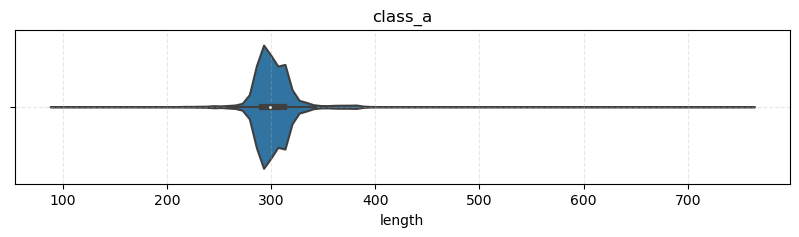

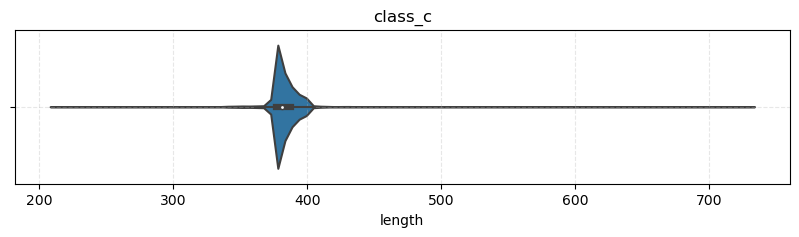

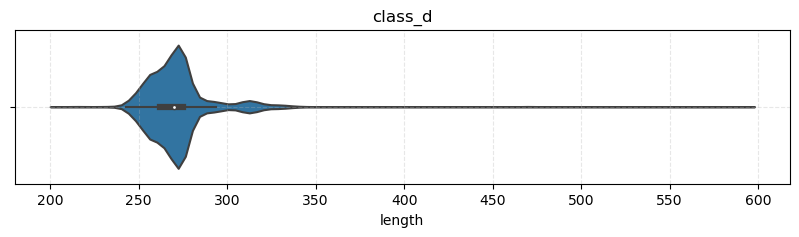

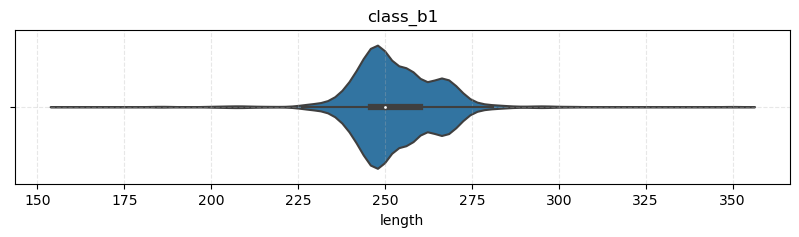

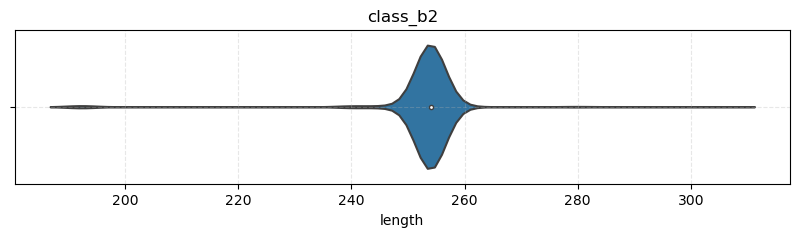

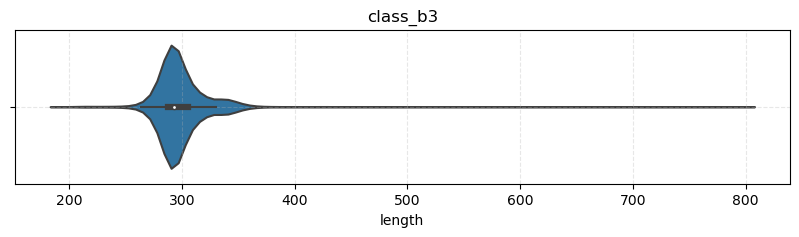

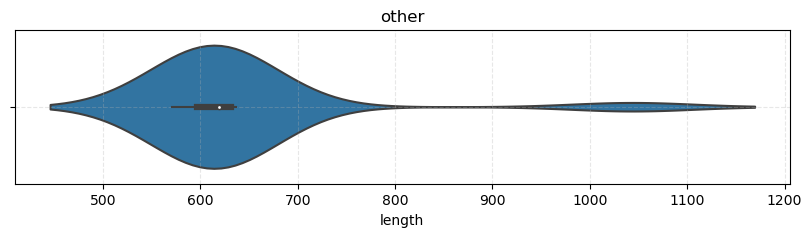

In [25]:
for bla in df.bla_class.unique():
    df_ = df[df.bla_class == bla]
    plt.figure(figsize=(10,2))
    sns.violinplot(df_, x="length")
    plt.grid(alpha=0.3, linestyle="--")
    plt.title(bla)
    plt.show()

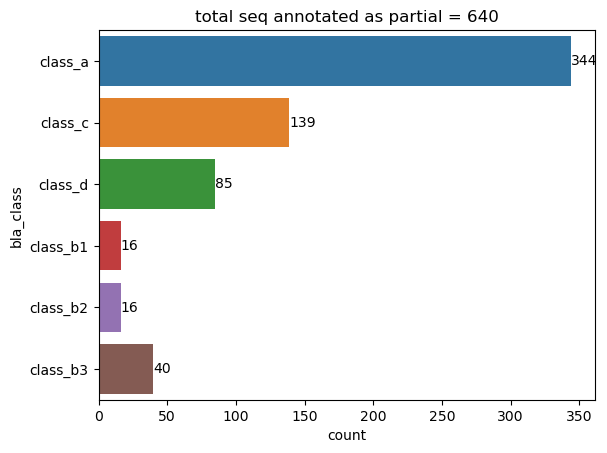

In [26]:
# get the seqs annotated as partials 
df_partials = df[df["#name"].str.contains("Partial|partial")]

# plot the seqs annotated as partials
ax = sns.countplot(df_partials, y="bla_class")
plt.title(f"total seq annotated as partial = {len(df_partials)}")
ax.bar_label(ax.containers[0]);

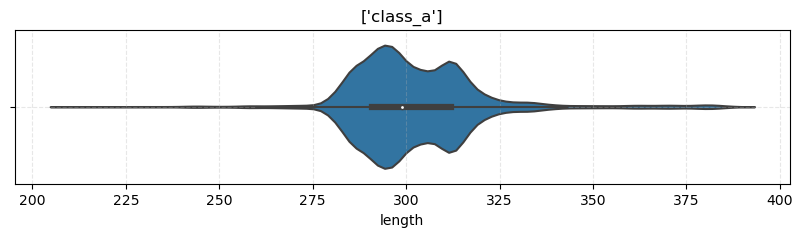

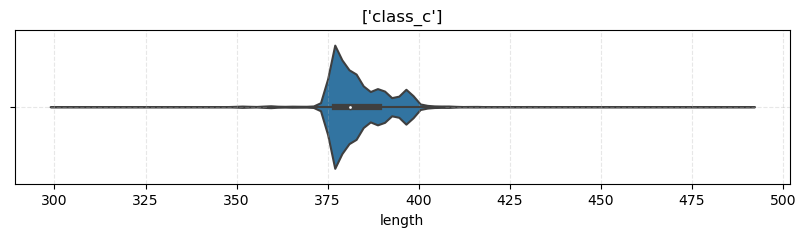

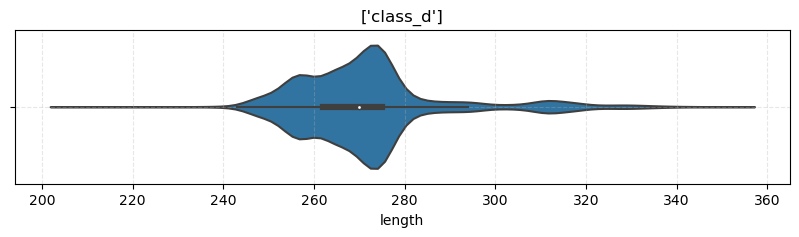

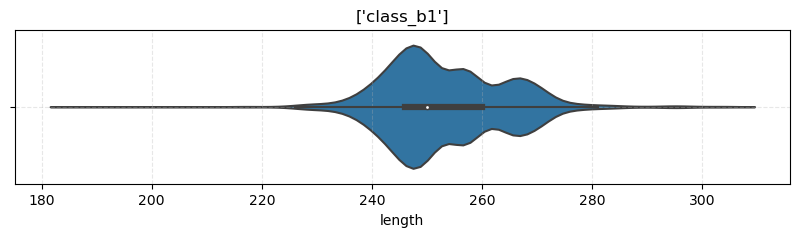

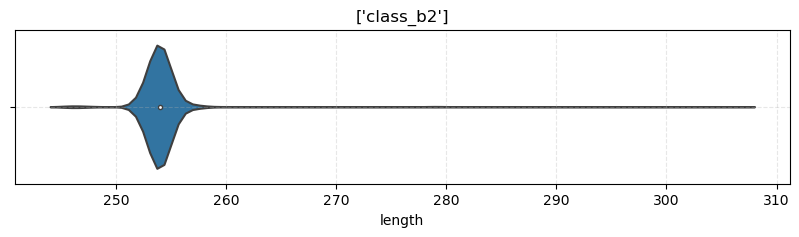

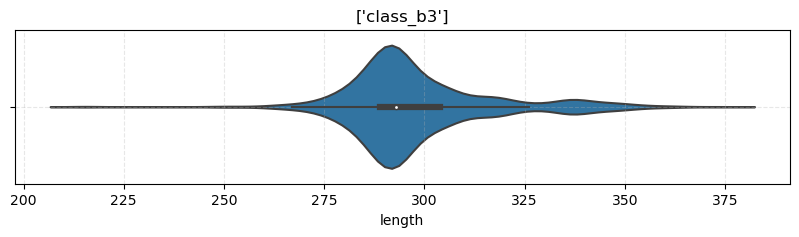

Number of removed seqs by the filter of median range
Class A  = 94
Class C  = 3
Class D  = 28
Class B1 = 3
Class B2 = 0
Class B3 = 17


In [27]:
# select seqs that not are partial
df_complete = df[~df.seq_id.isin(df_partials.seq_id)]

# split
df_bla_a  = df_complete[df_complete.bla_class == "class_a"]
df_bla_c  = df_complete[df_complete.bla_class == "class_c"]
df_bla_d  = df_complete[df_complete.bla_class == "class_d"]
df_bla_b1 = df_complete[df_complete.bla_class == "class_b1"]
df_bla_b2 = df_complete[df_complete.bla_class == "class_b2"]
df_bla_b3 = df_complete[df_complete.bla_class == "class_b3"]
df_bla_ot = df_complete[df_complete.bla_class == "other"]

# a fx to filter a dset by the median range
def filter_by_median(df, margin=0.3):
    
    # get the median
    median_length = df['length'].median()

    # get the limits and filter the data
    lower_lim = median_length - (median_length * margin)
    upper_lim = median_length + (median_length * margin)
    df_filtered = df[(df['length'] >= lower_lim) & (df['length'] <= upper_lim)]

    return df_filtered

# apply the filter 
df_a_filt  = filter_by_median(df_bla_a)
df_c_filt  = filter_by_median(df_bla_c)
df_d_filt  = filter_by_median(df_bla_d)
df_b1_filt = filter_by_median(df_bla_b1)
df_b2_filt = filter_by_median(df_bla_b2)
df_b3_filt = filter_by_median(df_bla_b3)

# plots
for ele in [df_a_filt, df_c_filt, df_d_filt, df_b1_filt, df_b2_filt, df_b3_filt]:
    plt.figure(figsize=(10,2))
    sns.violinplot(ele, x="length")
    plt.grid(alpha=0.3, linestyle="--")
    plt.title(ele["bla_class"].unique())
    plt.show()

# print info 
print("Number of removed seqs by the filter of median range")
print(f"Class A  = {len(df_bla_a) - len(df_a_filt)}")
print(f"Class C  = {len(df_bla_c) - len(df_c_filt)}")
print(f"Class D  = {len(df_bla_d) - len(df_d_filt)}")
print(f"Class B1 = {len(df_bla_b1) - len(df_b1_filt)}")
print(f"Class B2 = {len(df_bla_b2) - len(df_b2_filt)}")
print(f"Class B3 = {len(df_bla_b3) - len(df_b3_filt)}")

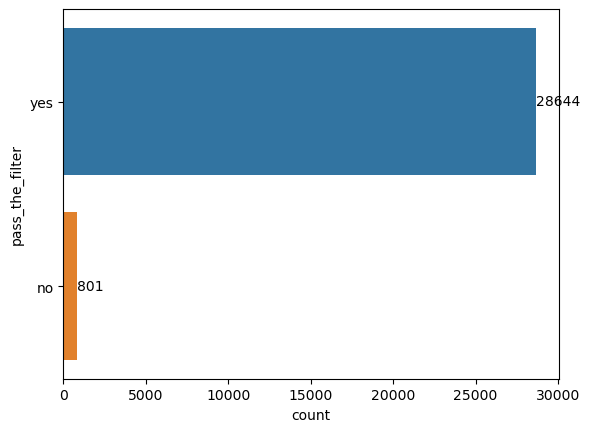

In [28]:
filtered_data = [df_a_filt, df_c_filt, df_d_filt, df_b1_filt, df_b2_filt, df_b3_filt]
df_complete_filt = pd.concat(filtered_data, ignore_index=True)

# add a label to the filtered seqs 
condition = df["seq_id"].isin(df_complete_filt["seq_id"])
df["pass_the_filter"] = np.where(condition, "yes", "no")

ax = sns.countplot(df, y="pass_the_filter")
ax.bar_label(ax.containers[0]);

In [29]:
# export filtered seqs
export_fasta(df_a_filt,  "../bldb/clean/fasta/bldb_a_filt.fasta")
export_fasta(df_c_filt,  "../bldb/clean/fasta/bldb_c_filt.fasta")
export_fasta(df_d_filt,  "../bldb/clean/fasta/bldb_d_filt.fasta")
export_fasta(df_b1_filt, "../bldb/clean/fasta/bldb_b1_filt.fasta")
export_fasta(df_b2_filt, "../bldb/clean/fasta/bldb_b2_filt.fasta")
export_fasta(df_b3_filt, "../bldb/clean/fasta/bldb_b3_filt.fasta")

 2108  for file in *filt.fasta; do mmseqs easy-cluster $file $file.clust30 tmp --min-seq-id 0.3 -c 0.8 --cov-mode 1; done
 2118  for file in *filt.fasta; do mmseqs easy-cluster $file $file.clust60 tmp --min-seq-id 0.6 -c 0.8 --cov-mode 1; done
 2121  for file in *filt.fasta; do mmseqs easy-cluster $file $file.clust90 tmp --min-seq-id 0.9 -c 0.8 --cov-mode 1; done
rm  */*all_seqs.fasta
for file in *rep_seq.fasta; do seqkit seq -n $file > $file.ids; done
cat *ids > bldb_clust90.ids


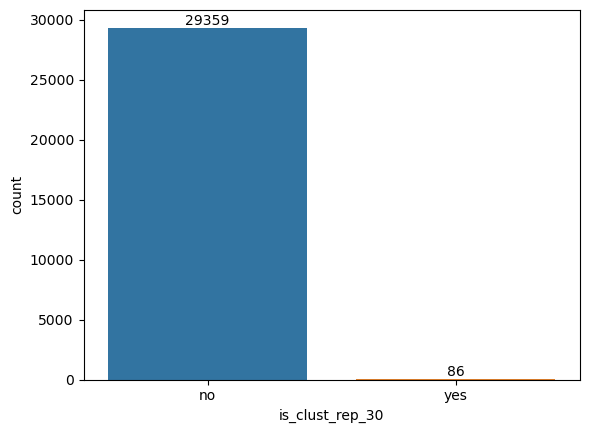

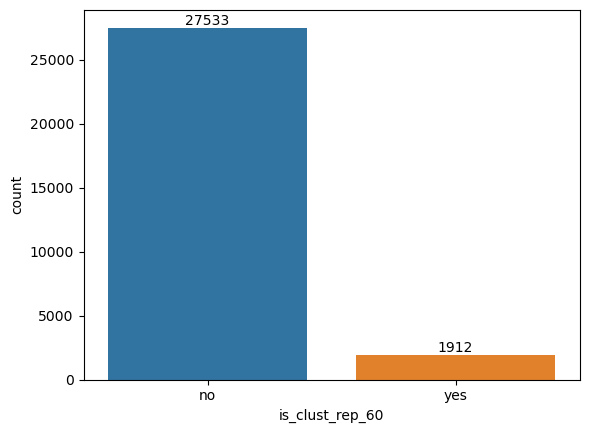

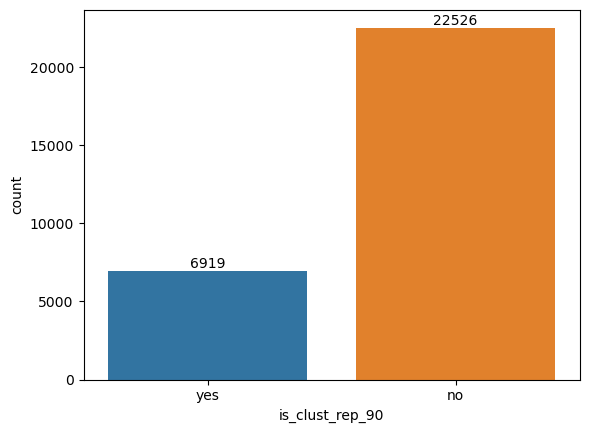

In [30]:
# perform clustering with mmseqs 
! cat ../bldb/clean/fasta/mmseqs/readme

clust30 = pd.read_csv("../bldb/clean/fasta/mmseqs/clust30/bldb_clust30.ids", names=["seq_id"])
clust60 = pd.read_csv("../bldb/clean/fasta/mmseqs/clust60/bldb_clust60.ids", names=["seq_id"])
clust90 = pd.read_csv("../bldb/clean/fasta/mmseqs/clust90/bldb_clust90.ids", names=["seq_id"])

# create col of rep cluster
df["is_clust_rep_30"] = np.where(df["seq_id"].isin(clust30.seq_id), "yes", "no")
df["is_clust_rep_60"] = np.where(df["seq_id"].isin(clust60.seq_id), "yes", "no")
df["is_clust_rep_90"] = np.where(df["seq_id"].isin(clust90.seq_id), "yes", "no")

for rep in ["is_clust_rep_30","is_clust_rep_60","is_clust_rep_90"]:
    ax = sns.countplot(df, x=rep)
    ax.bar_label(ax.containers[0])
    plt.show();

# AF2 data 

Go to the notebook "bldb_af2" for more details about the cross reference with uniprot and how to get the AF2 models 

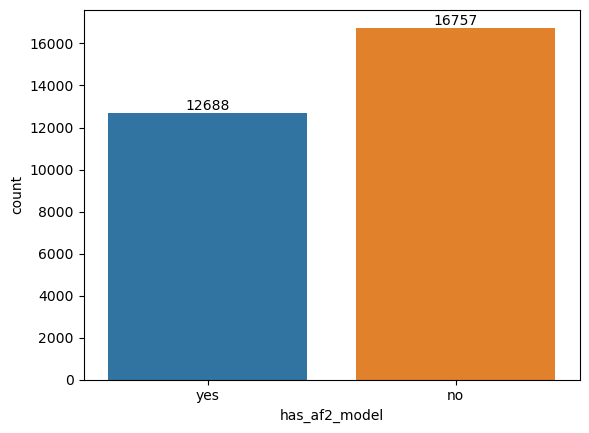

In [31]:
# load af2 data 
df_af2 = pd.read_parquet("../bldb/af2/plddt_values_nonredu.parquet")
df_af2.rename(columns={"uniprotSequence":"seq"}, inplace=True)
# label available models 
df["has_af2_model"] = np.where(df["seq"].isin(df_af2.seq), "yes", "no")

# plot
ax = sns.countplot(df, x="has_af2_model")
ax.bar_label(ax.containers[0])
plt.show();

In [32]:
df = df.merge(df_af2, on="seq", how="left")

In [33]:
# get the ss annotations by pydssp
df_ss = pd.read_csv("../bldb/af2/secondary_structure.csv", sep=" ", names=["secondary_structure", "model"])

# compute frecs
df_ss["frec_turn"]  = df_ss["secondary_structure"].apply(lambda x: x.count("-") / len(x))
df_ss["frec_helix"] = df_ss["secondary_structure"].apply(lambda x: x.count("H") / len(x))
df_ss["frec_beta"]  = df_ss["secondary_structure"].apply(lambda x: x.count("E") / len(x))

# generate a simplified version of the ss
def get_main_structure(seq):
    
    pattern = re.compile(r'(.)\1*')
    result = pattern.sub(r'\1', seq)
    
    return result

df_ss["simple_secondary_structure"] = df_ss["secondary_structure"].apply(get_main_structure)

# merge dsets
df = df.merge(df_ss, on="model", how="left")

# save data 
df.to_parquet("../bldb/clean/csv/bldb_dset.parquet")

! ls -lh ../bldb/clean/csv/bldb_dset.parquet

-rwxrwxrwx 1 gama gama 1.2G Apr 16 12:26 ../bldb/clean/csv/bldb_dset.parquet


In [34]:
df.columns

Index(['#name', 'seq', 'length', 'filename', 'bla_class', 'protein_name',
       'protein_family_filename', 'superfamily', 'protein_family', 'top_fam',
       'seq_id', 'ambler_class', 'alternative_protein_name', 'subfamily',
       'genpept_id', 'genbank_id', 'pubmed_id', 'seq_url', 'pdb_structures',
       'mutants', 'phenotype', 'functional_info', 'source', 'bitscore',
       'Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species',
       'phylo_group', 'phylo_group_genus', 'phylo_group_sp', 'bla_subclass',
       'esm1b', 'esm2_650m', 'esm2_3b', 'carp', 't5xlu50', 'molecular_weight',
       'aromaticity', 'instability', 'gravy', 'isoelectric_point', 'entropy',
       'helix', 'turn', 'sheet', 'pass_the_filter', 'is_clust_rep_30',
       'is_clust_rep_60', 'is_clust_rep_90', 'has_af2_model', 'model',
       'mean_plddt', 'resid_plddt', 'entryId', 'gene', 'uniprotAccession',
       'uniprotId', 'uniprotDescription', 'taxId', 'organismScientificName',
       'uniprotStart',

In [35]:
df

,#name,seq,length,filename,bla_class,protein_name,protein_family_filename,superfamily,protein_family,top_fam,...,bcifUrl,pdbUrl,paeImageUrl,paeDocUrl,dup_entry,secondary_structure,frec_turn,frec_helix,frec_beta,simple_secondary_structure
0,QOI11476.1|AAK-1| class A beta-lactamase AAK-1,MRYIRLCIISLFATLPLAVHASPQPLQQITLRESQLSGRVGTIEMD...,286,A-AAK-1-prot.fasta,class_a,AAK-1,AAK,SBL,AAK,No top,...,https://alphafold.ebi.ac.uk/files/AF-A0A867XYA...,https://alphafold.ebi.ac.uk/files/AF-A0A867XYA...,https://alphafold.ebi.ac.uk/files/AF-A0A867XYA...,https://alphafold.ebi.ac.uk/files/AF-A0A867XYA...,A0A867XYA1,------------------------HHHHHHHHHHH---EEEEEEEE...,0.437063,0.398601,0.164336,-H-E-E-E-E-H-E-H-H-EH-H-H-E-H-EH-H-H-E-E-E-H-
1,gi|5596421|emb|CAB51471.1|ACI-1| class A exten...,MKKFCFLFLIICGLMVFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-1-prot.fasta,class_a,ACI-1,ACI,SBL,ACI,No top,...,https://alphafold.ebi.ac.uk/files/AF-K9DIQ9-F1...,https://alphafold.ebi.ac.uk/files/AF-K9DIQ9-F1...,https://alphafold.ebi.ac.uk/files/AF-K9DIQ9-F1...,https://alphafold.ebi.ac.uk/files/AF-K9DIQ9-F1...,K9DIQ9,----------------------EE-----HHHHHHH--EEEEEEEE...,0.419014,0.390845,0.190141,-E-H-E-E-E-H-H-E-H-H-EH-H-H-E-H-EH-HE-H-H-E-E-...
2,WP_247239681.1|ACI-10| ACI family class A beta...,MKKFCFLFLIICGLMVFCPQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-10-prot.fasta,class_a,ACI-10,ACI,SBL,ACI,No top,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,WP_296333831.1|ACI-11| ACI family class A beta...,MKKFCFLFLIICGLMVFCPQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-11-prot.fasta,class_a,ACI-11,ACI,SBL,ACI,No top,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,WP_279133745.1|ACI-12| ACI family class A beta...,MKKFCFLFLIICGLMVFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-12-prot.fasta,class_a,ACI-12,ACI,SBL,ACI,No top,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29440,WP_019923896.1|XD-XD1-1| Duganella zoogloeoide...,MMPIDLDIVLARLLLAAAGSLAAGGAVWAVAVLCRRTLPALAQQRS...,631,XD-XD1-1-prot.fasta,other,XD-XD1-1,XD-XD1,Unknown,Unknown,Unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29441,KQN73069.1|XD-XD1-2| Duganella sp. Leaf61,MMPIDLDIVLARLLLAAAGSLAAGGAVWAVAVLCRRTLPALAQQRS...,631,XD-XD1-2-prot.fasta,other,XD-XD1-2,XD-XD1,Unknown,Unknown,Unknown,...,https://alphafold.ebi.ac.uk/files/AF-A0A0Q4NV2...,https://alphafold.ebi.ac.uk/files/AF-A0A0Q4NV2...,https://alphafold.ebi.ac.uk/files/AF-A0A0Q4NV2...,https://alphafold.ebi.ac.uk/files/AF-A0A0Q4NV2...,A0A0Q4NV26,-----HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH-HHHH--HH...,0.400951,0.486529,0.112520,-H-H-H-H-E-H-H-H-E-E-EH-H-H-H-H-H-H-H-H-E-E-E-...
29442,OFA09008.1|XD-XD1-3| Duganella phyllosphaerae,MMPIDLDVVLARLLLAAAGSLAAGGAVWAVAVLCRRTLPALAQQRS...,632,XD-XD1-3-prot.fasta,other,XD-XD1-3,XD-XD1,Unknown,Unknown,Unknown,...,https://alphafold.ebi.ac.uk/files/AF-A0A1E7X7M...,https://alphafold.ebi.ac.uk/files/AF-A0A1E7X7M...,https://alphafold.ebi.ac.uk/files/AF-A0A1E7X7M...,https://alphafold.ebi.ac.uk/files/AF-A0A1E7X7M...,A0A1E7X7M9,-----HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH-HHHH--HH...,0.400316,0.482595,0.117089,-H-H-H-H-E-H-E-H-H-E-E-EH-H-H-H-H-H-H-H-E-E-E-...
29443,SHM90367.1|XD-XD2-1| Duganella sacchari,MTGFDIALVRLLLAAAGSLAAGGAVWGVALLCRRYLPALAQHRSLW...,597,XD-XD2-1-prot.fasta,other,XD-XD2-1,XD-XD2,Unknown,Unknown,Unknown,...,https://alphafold.ebi.ac.uk/files/AF-A0A1M7MHI...,https://alphafold.ebi.ac.uk/files/AF-A0A1M7MHI...,https://alphafold.ebi.ac.uk/files/AF-A0A1M7MHI...,https://alphafold.ebi.ac.uk/files/AF-A0A1M7MHI...,A0A1M7MHI0,--HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH-HHHH--HHHH...,0.381910,0.495812,0.122278,-H-H-H-H-E-E-E-EH-H-H-H-H-H-H-H-H-E-E-E-E-H-E-...
